In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [24]:
from src.utils import *
from experiments.data_utils import *
from experiments.plot_utils import *
from experiments.hyperparam_tuning import *

In [4]:
target = 'performance' # performance, regression
data = 'bugbug_szz' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'roc_auc' # roc_auc, average_precision
model = 'rf' # lr, svm, mlp, rf, xgb
feature_type = 'traditional' # traditional, bow

In [5]:
output_dir = 'experiments/results'

In [84]:
data_map = {}

data_map['traditional'] = {
    'bugbug_buglevel': lambda target: get_ml_data_traditional('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data_traditional('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data_traditional('fixed_defect_szz', target, kind='commitlevel')
}
data_map['bow'] = {
    'bugbug_buglevel': lambda target: get_ml_data_bow('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data_bow('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data_bow('fixed_defect_szz', target, kind='commitlevel')
}

In [7]:
def get_results(data, feature_type, target, scoring, model):
    path = os.path.join(output_dir, f'{data}_{feature_type}_{target}_{scoring}_{model}.csv')
    results = pd.read_csv(path, index_col=0)
    if model == 'svm':
        results = results.drop('param_kernel__gamma', axis=1, errors='ignore')
    results = results.replace({np.nan: None})
    return results
results = get_results(data, feature_type, target, scoring, model)
results

,param_model,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,param_sampler,mean_fit_time,std_fit_time,mean_test_score,std_test_score,rank_test_score
17,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.775085,0.383149,0.775552,0.015799,1
71,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.732983,0.390042,0.775552,0.015799,1
14,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.758890,0.126997,0.775552,0.015799,1
84,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.026658,0.245133,0.775552,0.015799,1
27,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.751893,0.378498,0.775552,0.015799,1
...,...,...,...,...,...,...,...,...,...,...
25,RandomForestClassifier,20.0,2,5,RandomOverSampler(random_state=0),10.177250,2.404207,0.656387,0.015048,96
11,RandomForestClassifier,20.0,5,5,RandomOverSampler(random_state=0),11.107923,2.376426,0.656387,0.015048,96
13,RandomForestClassifier,None,2,5,SMOTE(random_state=0),36.590157,8.066854,0.613069,0.031139,98
42,RandomForestClassifier,None,5,5,SMOTE(random_state=0),22.053792,6.298486,0.610252,0.034565,99


In [8]:
X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 317 positive 0.34% - negative 91871 99.66%
X.shape=(92188, 301)



In [9]:
def get_params(results):
    params = results[[c for c in results.columns if 'param' in c]]
    params = params.rename(lambda c: c[6:], axis=1) # remove param_
    return params
params = get_params(results)

In [10]:
model_map = {
    'lr': LogisticRegression(random_state=0, solver='saga'),
    'svm': LinearSVC(random_state=0),
    'mlp': MLPClassifier(random_state=0),
    'rf': RandomForestClassifier(random_state=0),
    'xgb': xgboost.XGBClassifier(random_state=0, n_jobs=4, use_label_encoder=False, eval_metric='logloss')
}

In [11]:
def get_best_params(model, params):
    best_params = dict(params.iloc[0])

    best_params['model'] = model_map[model]
    try:
        best_params['sampler'] = eval(best_params['sampler'])
    except:
        best_params['sampler'] = None
    
    return best_params

best_params = get_best_params(model, params)
best_params

{'model': RandomForestClassifier(random_state=0),
 'model__max_depth': None,
 'model__min_samples_split': 2,
 'model__n_estimators': 150,
 'sampler': RandomUnderSampler(random_state=0)}

In [12]:
pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
pipeline.set_params(**best_params)
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sampler', RandomUnderSampler(random_state=0)),
                ('model',
                 RandomForestClassifier(n_estimators=150, random_state=0))])

In [13]:
results.iloc[0]

param_model                                   RandomForestClassifier
param_model__max_depth                                          None
param_model__min_samples_split                                     2
param_model__n_estimators                                        150
param_sampler                     RandomUnderSampler(random_state=0)
mean_fit_time                                               1.775085
std_fit_time                                                0.383149
mean_test_score                                             0.775552
std_test_score                                              0.015799
rank_test_score                                                    1
Name: 17, dtype: object

In [ ]:
from sklearn.model_selection import cross_val_score
y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
res = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=tscv, n_jobs=5)
res, res.mean(), res.std()

In [ ]:
for ix_train, ix_val in tscv.split(X_train, y_train):
    print(f'{ix_train=}, {ix_val=}')
    print(f'{y_train[ix_train].sum()=}, {y_train[ix_val].sum()=}')
    pipeline.fit(X_train[ix_train, :], y_train[ix_train])

    y_score = pipeline.predict_proba(X_train[ix_val, :])[:,1]
    print('ROC AUC:', metrics.roc_auc_score(y_train[ix_val], y_score))
    print('AVG PREC:', metrics.average_precision_score(y_train[ix_val], y_score))
    plot_roc_curve(pipeline, X_train[ix_val, :], y_train[ix_val])
    plot_precision_recall_curve_with_f1(pipeline,  X_train[ix_val, :], y_train[ix_val])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_train)[:,1]
metrics.roc_auc_score(y_train, y_score), metrics.average_precision_score(y_train, y_score)

In [ ]:
plot_roc_curve(pipeline, X_train, y_train)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score), metrics.average_precision_score(y_test, y_score)

In [ ]:
plot_roc_curve(pipeline, X_test, y_test)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.boxplot(results['mean_test_score'])

In [ ]:
make_directory('experiments/plots')

In [91]:
def fit_best_model(model, data, feature_type, target, scoring, X_train, y_train):
    print(model)
    results = get_results(data, feature_type, target, scoring, model)
    params = get_params(results)
    best_params = get_best_params(model, params)
    print(best_params)

    pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
    pipeline.set_params(**best_params)
    if feature_type == 'bow':
        pipeline.set_params(scaler=None)

    pipeline.fit(X_train, y_train)

    return pipeline

def fit_all_models(target, data, feature_type, scoring):
    X, y, features = data_map[feature_type][data](target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    fitted_pipelines = []
    for model in ['lr', 'svm', 'mlp', 'rf', 'xgb']:
        try:
            pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)
            fitted_pipelines.append((model, pipeline))
        except Exception as e:
            print(e)

    return fitted_pipelines, X_train, X_test, y_train, y_test
    

In [87]:
def plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test):
    _X = X_test
    _y = y_test

    roc_fig, roc_ax = plt.subplots(figsize=(12,8))
    roc_ax.axline([0,0], [1,1], color='black')
    roc_ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')

    pr_fig, pr_ax = plt.subplots(figsize=(12,8))
    R, P = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
    F1 = 2 * R * P / (R + P)
    CS = pr_ax.contour(R, P, F1, levels=np.arange(0.1, 1, 0.1), alpha=0.5, colors='gray')
    pr_ax.clabel(CS, inline=1)
    pr_ax.set(xlabel='Recall', ylabel='Precision', title='Recall-Precision Curve')


    for (model, pipeline) in fitted_pipelines:

        if type(pipeline['model']) is LinearSVC:
            y_score = pipeline.decision_function(_X)
        else:
            y_score = pipeline.predict_proba(_X)[:,1]

        fpr, tpr, thresholds = metrics.roc_curve(_y, y_score)
        roc_ax.plot(fpr, tpr, label=model)
        
        precision, recall, thresholds = metrics.precision_recall_curve(_y, y_score)
        pr_ax.plot(recall, precision, label=model)

    roc_ax.legend()
    pr_ax.legend()

    roc_fig.tight_layout()
    roc_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_roc.pdf')

    pr_fig.tight_layout()
    pr_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_pr.pdf')
    plt.show()


In [88]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision

In [89]:
def get_best_f1_threshold(clf, X, y):
    y_score = get_y_score(clf, X)
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_score)
    precision = precision[:-1] # last one is 0
    recall = recall[:-1] # last one is 1

    D = precision + recall
    P = precision[D != 0]
    R = recall[D != 0]
    F1 = 2 * P * R / D[D != 0]
    T = thresholds[D != 0]

    amax = F1.argmax()
    return T[amax], F1[amax]

In [90]:
def print_classification_report_at_threshold(clf, X, y, threshold):
    y_score = get_y_score(clf, X)
    y_pred = y_score >= threshold
    print(f'{threshold=}')
    report = metrics.classification_report(y, y_pred)
    print(report)
    roc_auc = metrics.roc_auc_score(y, y_score)
    average_precision = metrics.average_precision_score(y, y_score)
    print(f'{roc_auc=} {average_precision=}')

In [35]:
fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, feature_type, scoring)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=5.402024656860861, random_state=0, solver='saga'), 'model__C': 0.021059163929894, 'model__penalty': 'l2', 'sampler': SMOTE(random_state=0)}
svm
{'kernel__degree': 5, 'kernel__kernel': 'linear', 'model': LinearSVC(C=164.87171291936357, random_state=0), 'model__C': 7.156090624884973, 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mlp
{'model': MLPClassifier(alpha=0.0134505118791459, hidden_layer_sizes=100,
              learning_rate_init=0.0001, random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.2431362008261892, 'model__hidden_layer_sizes': 200, 'model__learning_rate_init': 0.0041238725976079, 'sampler': SMOTE(random_state=0)}
rf
{'model': RandomForestClassifier(max_depth=15.0, n_estimators=150, random_state=0), 'model__max_depth': 10.0, 'model__min_samples_split': 2, 'model__n_estimators': 114, 'sampler': RandomUnderSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.3613721957013188, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_

In [36]:
for name, clf in fitted_pipelines:
    print(f'\n~~~~ {name} ~~~~\n')
    print('TRAIN\n')
    t, f1 = get_best_f1_threshold(clf, X_train, y_train)
    print(f'{t=}, {f1=}')
    print_classification_report_at_threshold(clf, X_train, y_train, t)
    print('\n\nTEST\n')
    t2, f1 = get_best_f1_threshold(clf, X_test, y_test)
    print(f'{t2=}, {f1=}')
    print_classification_report_at_threshold(clf, X_test, y_test, t)


~~~~ lr ~~~~

TRAIN

t=0.7591930709879939, f1=0.1266220998820291
threshold=0.7591930709879939
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     53054
           1       0.13      0.13      0.13      1271

    accuracy                           0.96     54325
   macro avg       0.55      0.55      0.55     54325
weighted avg       0.96      0.96      0.96     54325

roc_auc=0.6954523376965773 average_precision=0.0660318578921666


TEST

t2=0.7737611302323931, f1=0.1712707182320442
threshold=0.7591930709879939
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5856
           1       0.15      0.18      0.16       181

    accuracy                           0.94      6037
   macro avg       0.56      0.57      0.57      6037
weighted avg       0.95      0.94      0.95      6037

roc_auc=0.6859706623796153 average_precision=0.08578758641029414

~~~~ svm ~~~~

TRAIN

t=-0.833129217504

In [ ]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test)

In [ ]:
feature_type = 'traditional'
for target, data, scoring in [
    ('performance', 'bugbug_buglevel', 'roc_auc'),
    ('regression', 'bugbug_buglevel', 'roc_auc'),
    ('performance', 'bugbug_szz', 'roc_auc'),
    ('performance', 'fixed_defect_szz', 'roc_auc'),
    
    ('performance', 'bugbug_buglevel', 'average_precision'),
    ('regression', 'bugbug_buglevel', 'average_precision'),
    ('performance', 'bugbug_szz', 'average_precision'),
    ('performance', 'fixed_defect_szz', 'average_precision'),
]:
    print(f'{target=}, {data=}, {feature_type=}, {scoring=}')
    fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, scoring)
    plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test)

In [54]:
import shap
def plot_important_features(clf, X, feature_names, max_display=10):
    explainer = shap.Explainer(clf, X, feature_names=feature_names)
    print(explainer)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=max_display, feature_names=feature_names)
    plt.show()

In [78]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'traditional'
model = 'lr'

target = 'performance'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=5.402024656860861, random_state=0, solver='saga'), 'model__C': 0.021059163929894, 'model__penalty': 'l2', 'sampler': SMOTE(random_state=0)}


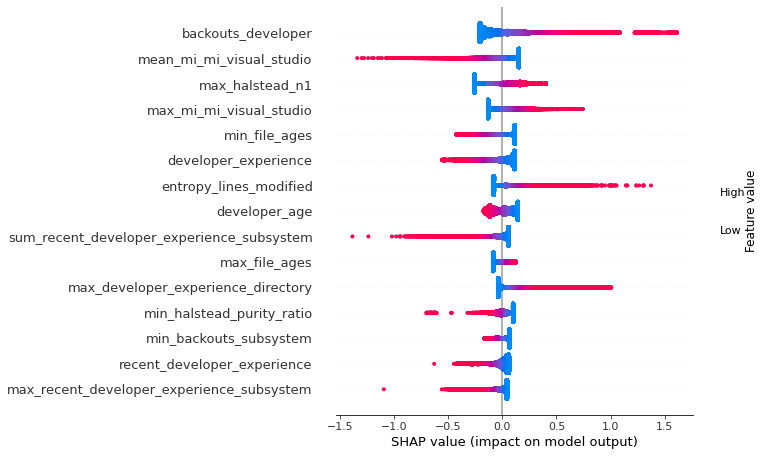

In [79]:
X_train_scaled = perf_pipeline['scaler'].transform(X_train)
perf_model = perf_pipeline['model']

plot_important_features(perf_model, X_train_scaled, features.columns, max_display=15)

best F1: 0.1712707182320442 at precision=0.1712707182320442 recall=0.1712707182320442


invalid value encountered in true_divide


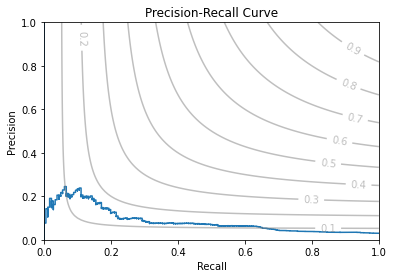

threshold=0.7591930709879939
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5856
           1       0.15      0.18      0.16       181

    accuracy                           0.94      6037
   macro avg       0.56      0.57      0.57      6037
weighted avg       0.95      0.94      0.95      6037

roc_auc=0.6859706623796153 average_precision=0.08578758641029414


4.9185019222445705

In [80]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

y_score = get_y_score(perf_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [81]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

regression: 11552 positive 19.14% - negative 48810 80.86%
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=0.021059163929894, random_state=0, solver='saga'), 'model__C': 5.402024656860861, 'model__penalty': 'l2', 'sampler': RandomOverSampler(random_state=0)}


The max_iter was reached which means the coef_ did not converge


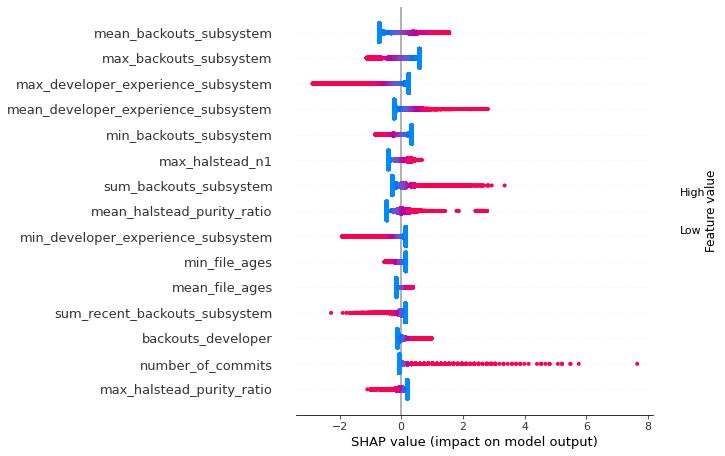

In [82]:
X_train_scaled = reg_pipeline['scaler'].transform(X_train)
reg_model = reg_pipeline['model']

plot_important_features(reg_model, X_train_scaled, features.columns, max_display=15)

best F1: 0.4009433962264151 at precision=0.30115146147032773 recall=0.599647266313933


invalid value encountered in true_divide


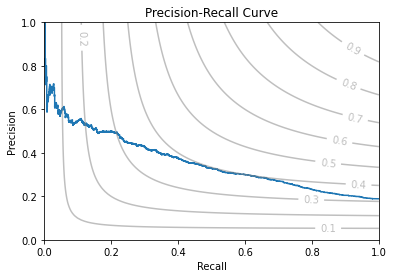

threshold=0.5208349722252273
              precision    recall  f1-score   support

           0       0.87      0.73      0.80      4903
           1       0.32      0.53      0.40      1134

    accuracy                           0.70      6037
   macro avg       0.59      0.63      0.60      6037
weighted avg       0.77      0.70      0.72      6037

roc_auc=0.6773532635419915 average_precision=0.3607692523323134


1.677767974481836

In [83]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

y_score = get_y_score(reg_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [104]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'bow'
model = 'lr'

target = 'performance'

X, y, features_names = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

performance: 1452 positive 2.41% - negative 58910 97.59%
X.shape=(60362, 50000)

lr
{'model': LogisticRegression(C=0.1881173731646983, random_state=0, solver='saga'), 'model__C': 0.6176851478255081, 'model__penalty': 'l2', 'sampler': None}


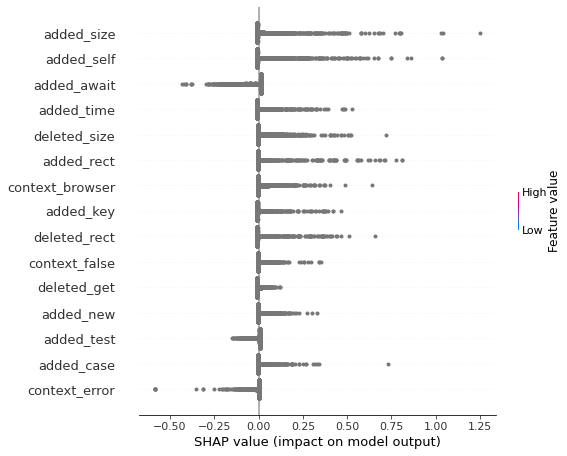

In [105]:
perf_model = perf_pipeline['model']
plot_important_features(perf_model, X_test, features_names, max_display=15)

best F1: 0.13953488372093023 at precision=0.175 recall=0.11602209944751381


invalid value encountered in true_divide


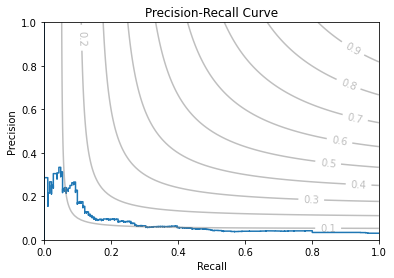

threshold=0.08291349319673007
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5856
           1       0.14      0.12      0.13       181

    accuracy                           0.95      6037
   macro avg       0.56      0.55      0.55      6037
weighted avg       0.95      0.95      0.95      6037

roc_auc=0.6444115493765661 average_precision=0.07641096540835493


4.67375162754689

In [106]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

y_score = get_y_score(perf_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [101]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

regression: 11552 positive 19.14% - negative 48810 80.86%
X.shape=(60362, 50000)

lr
{'model': LogisticRegression(C=0.6176851478255081, random_state=0, solver='saga'), 'model__C': 0.1881173731646983, 'model__penalty': 'l2', 'sampler': None}


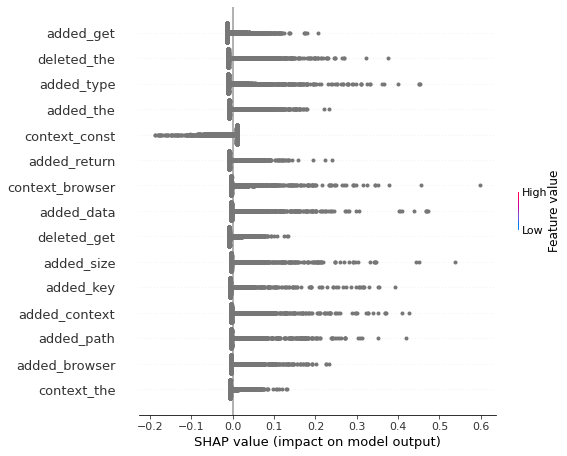

In [102]:
reg_model = reg_pipeline['model']
plot_important_features(reg_model, X_test, features_names, max_display=15)

best F1: 0.36358574610244987 at precision=0.2656631407648495 recall=0.5758377425044092


invalid value encountered in true_divide


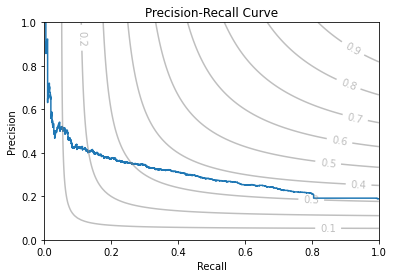

threshold=0.24531288661846556
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4903
           1       0.32      0.38      0.35      1134

    accuracy                           0.73      6037
   macro avg       0.58      0.60      0.59      6037
weighted avg       0.75      0.73      0.74      6037

roc_auc=0.6306445573221017 average_precision=0.30538359434105167


1.6778916413387486

In [103]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

y_score = get_y_score(reg_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()